## Sandbox for experiments and tests

## networkX

In [18]:
%pylab inline
plt.rcParams["figure.figsize"] = [20,10]
import networkx as nx
from networkx.algorithms import bipartite
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing

Populating the interactive namespace from numpy and matplotlib


In [106]:
raw_data = pd.read_csv("data/t1.csv", delimiter=";").fillna(0.0)
raw_data.head(5)

,ID,Name,Journal,Date,Debit,Credit
0,1,Trade Receivables,Sales ledger,01/01/2017,121.0,0.0
1,1,Revenue,Sales ledger,01/01/2017,0.0,100.0
2,1,Tax,Sales ledger,01/01/2017,0.0,21.0
3,2,Cost of Sales,Journal ledger,01/01/2017,80.0,0.0
4,2,Inventories,Journal ledger,01/01/2017,0.0,80.0


In [107]:
# TODO try another kind of normalization, unit-normal etc.
def normalize(df, by="ID"):
    dfN = df.copy()
    titles = ["Debit", "Credit"]
    groups = dfN.groupby(by)
    sums = groups[titles].transform(np.sum)
    for column in titles:
        dfN[column] = dfN[column]/sums[column]
    dfN["from"] = dfN["Credit"] > 0.0
    return dfN

data = normalize(raw_data)
data.head(5)

,ID,Name,Journal,Date,Debit,Credit,from
0,1,Trade Receivables,Sales ledger,01/01/2017,1.0,0.000000,False
1,1,Revenue,Sales ledger,01/01/2017,0.0,0.826446,True
2,1,Tax,Sales ledger,01/01/2017,0.0,0.173554,True
3,2,Cost of Sales,Journal ledger,01/01/2017,1.0,0.000000,False
4,2,Inventories,Journal ledger,01/01/2017,0.0,1.000000,True


In [207]:
def construct_graph(df):
        B = nx.DiGraph()
        B.add_nodes_from(df['ID'], bipartite=0)
        B.add_nodes_from(df['Name'], bipartite=1)
        B.add_weighted_edges_from(
            [(row['Name'], row['ID'], row["Credit"]) if row["from"]==True 
             else (row['ID'], row['Name'], row["Debit"]) 
             for idx, row in df.iterrows()], 
            weight='weight')
        return B

def plot_network(df):
    colors = {0: "Blue", 1: "Red"}
    B = construct_graph(df)
    # print(B.edges(data=True))
    pos = {node:[0, i] for i,node in enumerate(df['Name'])}
    pos.update({node:[1, i] for i,node in enumerate(df['ID'])})
    arc_weight=nx.get_edge_attributes(B,'weight')
    node_col = ["Red" if d['bipartite']==0 else "Blue" for n, d in B.nodes(data=True)]
    nx.draw(B, pos, node_color= node_col, with_labels=False, node_size=250)
    nx.draw_networkx_edges(B, pos, arrowsize=30)
    nx.draw_networkx_edge_labels(B, pos, node_size=250, edge_labels=arc_weight, font_size=16)
    for p in pos:  # raise text positions
        pos[p][1] += 0.25
    nx.draw_networkx_labels(B, pos, font_size=16)

    plt.show()

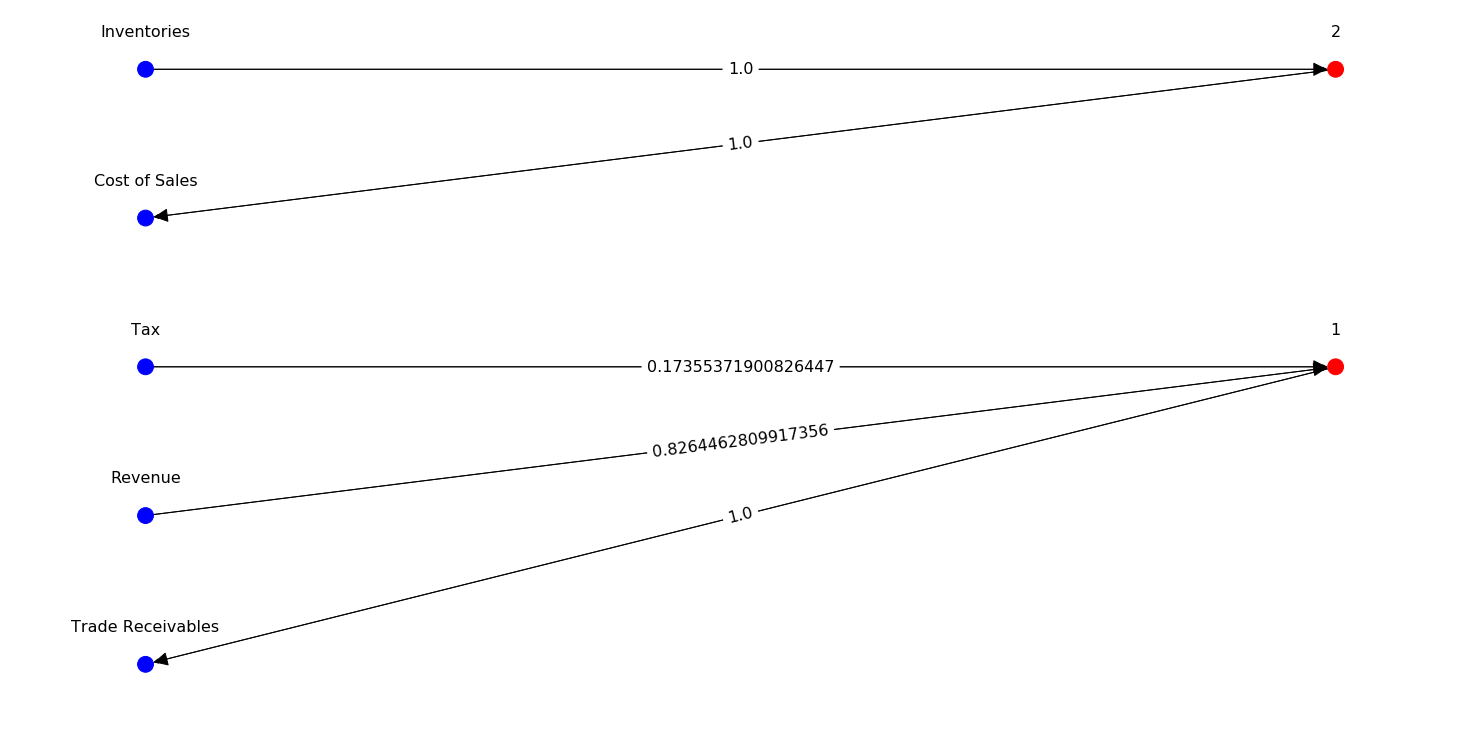

In [208]:
plot_network(data)

### Connection to Marcel's DB

Debit == +positive \\
Credit == -negative

In [160]:
def upload_data(cnx):
    # Loading data from db
    db_data = pd.read_sql_query("SELECT * FROM EntryRecords LIMIT 10", cnx).drop(["ID", "ValueIncorrect"], axis=1)
    # Split into two columns: Debit and Credit
    db_data["Debit"] = db_data["ValueCorrect"][db_data["ValueCorrect"] > 0.0]
    db_data["Credit"] = -db_data["ValueCorrect"][db_data["ValueCorrect"] < 0.0]
    db_data.fillna(0.0, inplace=True)
    db_data.rename(index=str, columns={"TID": "ID"}, inplace=True)
    return db_data

In [175]:
import sqlite3

db_data = normalize(upload_data(cnx))
db_data.head(10)

,ID,Name,ValueCorrect,Debit,Credit,from
0,1,Revenue,-214.00,0.0,0.943396,True
1,1,Tax,-12.84,0.0,0.056604,True
2,1,Trade receivables,226.84,1.0,0.000000,False
3,2,Cost of Sales,214.00,1.0,0.000000,False
4,2,Inventory,-214.00,0.0,1.000000,True
5,3,Revenue,-328.00,0.0,0.826446,True
6,3,Tax,-68.88,0.0,0.173554,True
7,3,Trade receivables,396.88,1.0,0.000000,False
8,4,Cost of Sales,328.00,1.0,0.000000,False
9,4,Inventory,-328.00,0.0,1.000000,True


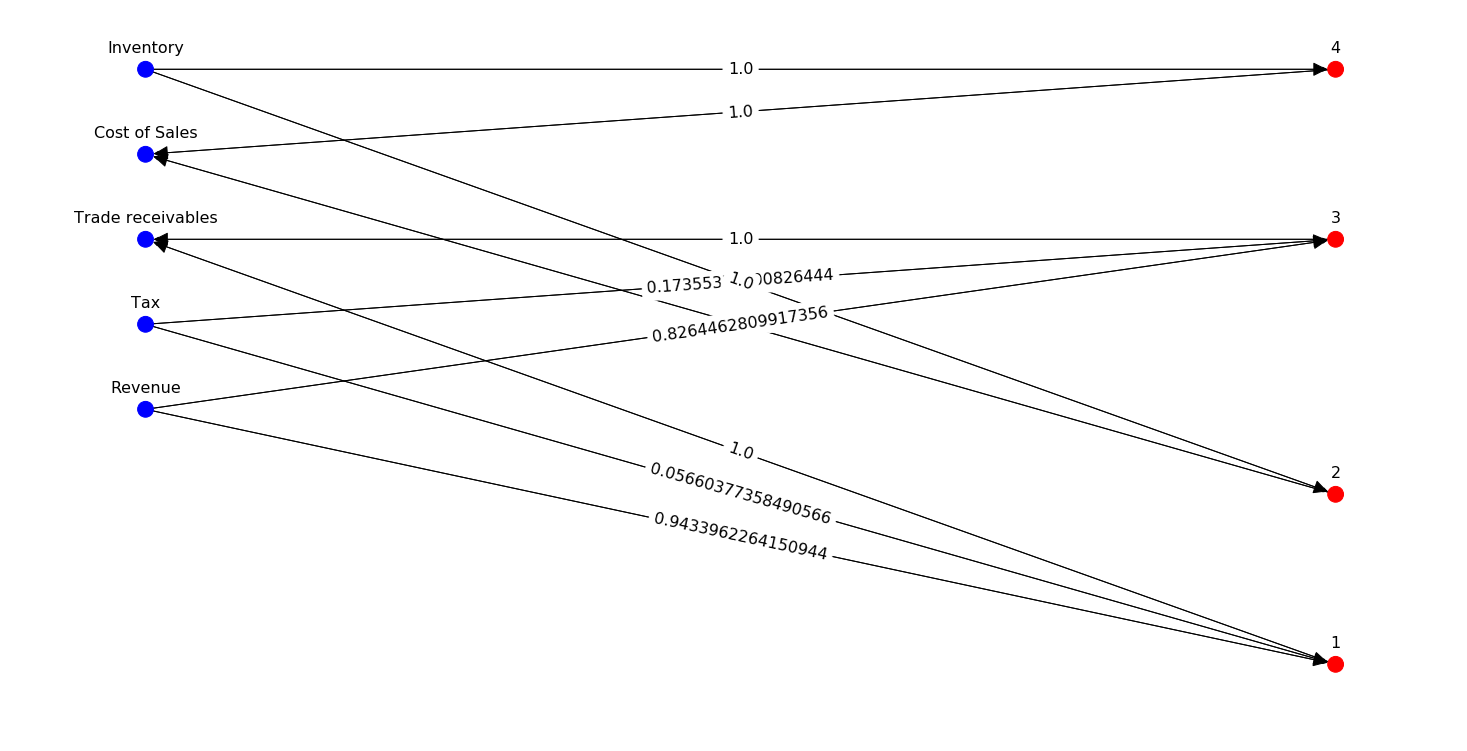

In [209]:
plot_network(db_data)

In [334]:
G = construct_graph(db_data)
# TODO optimize if initial vertex is equal the destination vertex
def step(G, vertex, d="IN"):
    ws = list()
    if d=="IN":
            ins = G.in_edges(vertex, data=True)
            if len(ins)>0:
                ws = [edge[-1]["weight"] for edge in ins]
                ws = ws/np.sum(ws)
                ins = [edge[0] for edge in ins]
                return np.random.choice(ins, p=ws)
            else:
                return -1
    elif d=="OUT":
            ins = G.out_edges(vertex, data=True)
            if len(ins)>0:
                ws = [edge[-1]["weight"] for edge in ins]
                ws = ws/np.sum(ws)
                ins = [edge[1] for edge in ins]
                return np.random.choice(ins, p=ws)
            else:
                return -1
# -------
from collections import Counter
cnt = Counter([step(G, step(G, 1), d="OUT") for _ in range(30)])
cnt

Counter({3: 16, 1: 14})

In [261]:
ins = G.in_edges(1, data=True)
ws = [edge[-1]["weight"] for edge in G.in_edges(1, data=True)]
ins = [edge[0] for edge in G.in_edges(1, data=True)]
np.random.choice(ins, p=ws)

'Revenue'

In [341]:
import random
def getNeighbors(G, vetrtex):
    return list(G.successors(vertex))+list(G.predecessors(vertex))
def randomWalk(G, vertex=None, lenght=1, direction="IN"):
    mask = {"IN": "OUT", "OUT": "IN"}
    context = list()
    if vertex is None:
        context.append(random.choice(list(G.nodes)))
    else:
        context.append(vertex)
    cur_v = context[-1]
    while len(context)<lenght+1:
        try:
            new_v = step(G, step(G, cur_v, d=direction), d=mask[direction])
        except nx.NetworkXError:
            break
        if new_v!=cur_v:
            context.append(new_v)
            cur_v = new_v
    return context
# ------
randomWalk(G, vertex=1, direction="IN")

[1, 3]